In [3]:
import pandas as pd
import string
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from spacy.lang.it import Italian
import simplemma
from sklearn import metrics
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

nltk.download('punkt')
punctuations = string.punctuation

nltk.download('stopwords')
stop_words = set(stopwords.words('italian'))

parser = Italian()
stemmer = SnowballStemmer('italian')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
# function used to perform GPUs calculus in Google Colab in order to avoid errors

import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [5]:
! pip install simplemma

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 MB 5.5 MB/s eta 0:00:00


Function used to evaluate classifier's performances

In [ ]:
def evaluating_results(X_test, y_test, classifier):
    predicted = classifier.predict(X_test)
    predicted = [int(x) for x in predicted]

    acc = metrics.accuracy_score(y_test, predicted)
    print("Accuracy:", acc)
    precision = metrics.precision_score(y_test, predicted, average='macro')
    recall = metrics.recall_score(y_test, predicted, average='macro')
    fm = metrics.f1_score(y_test, predicted, average='macro')
    print("P={0}, R={1}, F1={2}".format(precision, recall, fm))
    print("======================================================")
    print(metrics.classification_report(y_test, predicted, digits=4))

    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    cm = confusion_matrix(y_test, predicted)
    print(cm)

    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
    disp.plot()

Function used to preprocess the text, used inside the TfIdfVectorizer function

In [6]:

def preprocessing_text(sentence):

    mytokens = parser(sentence)
    mytokens = [ word.text for word in mytokens ]
    mytokens = [word.lower() for word in mytokens]

    # remove URL \ url
    mytokens = [re.sub(r"URL|url", "", token) for token in mytokens]

    # remove @user
    mytokens = [re.sub(r'@\w+\s*', "", token) for token in mytokens]

    # remove words with numbers
    mytokens = [re.sub(r'\b\w*\d\w*\b', "", token) for token in mytokens]
    mytokens = [re.sub(r"\.{2,4}", "", token) for token in mytokens]

    # remove extra whitespaces
    mytokens = [re.sub(r"\s+", "", token) for token in mytokens]
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    mytokens = [simplemma.lemmatize(token, lang='it') for token in mytokens]

    mytokens = [stemmer.stem(token) for token in mytokens]
    return mytokens

In [8]:
#training set
d = pd.read_csv('./trainingset_tweet.tsv', sep='\t', names=["id", "text", "hs", "st"], encoding='utf-8')
d = d.drop(0)   # drop the first row with column's names

task_label = "hs"  # change this to change the task [tasks: hs / st]
X_train = d['text']     
y_train = d[task_label] 
print(d.info)

# test set with tweets
t = pd.read_csv('./testset_tweet.tsv', sep='\t', names=["id", "text", "hs", "st"], encoding='utf-8')
t = t.drop(0)

X_test = t['text'] # the features
y_test = t[task_label] # the labels

#test set with news
t_news = pd.read_csv('./testset_news.tsv', sep='\t', names=["id", "text", "hs", "st"], encoding='utf-8')

X_test_news = t_news['text']
y_test_news = t_news[task_label]

<bound method DataFrame.info of         id                                               text hs st
1     2066  È terrorismo anche questo, per mettere in uno ...  0  0
2     2045  @user @user infatti finché ci hanno guadagnato...  0  0
3       61  Corriere: Tangenti, Mafia Capitale dimenticata...  0  0
4     1259  @user ad uno ad uno, perché quando i migranti ...  0  0
5      949  Il divertimento del giorno? Trovare i patrioti...  0  0
...    ...                                                ... .. ..
6833  9340  Gli stati nazionali devono essere pronti a rin...  0  0
6834  9121  Il ministro dell'interno della Germania #Horst...  0  0
6835  8549  #Salvini: In Italia troppi si sono montati la ...  0  0
6836  9240  @user @user Chi giubila in buona fede non ha c...  0  0
6837  8000  I giovani cristiani in #Etiopia sono indotti d...  0  1

[6837 rows x 4 columns]>


In [9]:
from collections import Counter

print(Counter(y_train))

Counter({'0': 4071, '1': 2766})
Counter({0: 641, 1: 621})


In [10]:
vector = TfidfVectorizer(tokenizer = preprocessing_text, lowercase = True)

X_train = vector.fit_transform(X_train)
X_test = vector.transform(X_test)
X_test_news = vector.transform(X_test_news)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Undersample of the dataset with the near miss algorithm

In [11]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import NearMiss
from matplotlib import pyplot
from numpy import where

undersample = NearMiss(version=2, n_neighbors=5)

X_undersampled, y_undersampled = undersample.fit_resample(X_train, y_train)


Oversample of the dataset with the SMOTE algorithm

In [12]:
from imblearn.over_sampling import SMOTE

sm = SMOTE()
X_smote, y_smote = sm.fit_resample(X_train, y_train)
y_smote = [int(x) for x in y_smote]

Counter(y_smote)

Counter({0: 4071, 1: 4071})

Training of the classifier with the original training set

TWEETS - ORIGINAL DATASET
Accuracy: 0.7290015847860539
P=0.729483282674772, R=0.7293103318335632, F1=0.7289845680872868
              precision    recall  f1-score   support

           0     0.7447    0.7098    0.7268       641
           1     0.7143    0.7488    0.7311       621

    accuracy                         0.7290      1262
   macro avg     0.7295    0.7293    0.7290      1262
weighted avg     0.7297    0.7290    0.7290      1262

[[455 186]
 [156 465]]


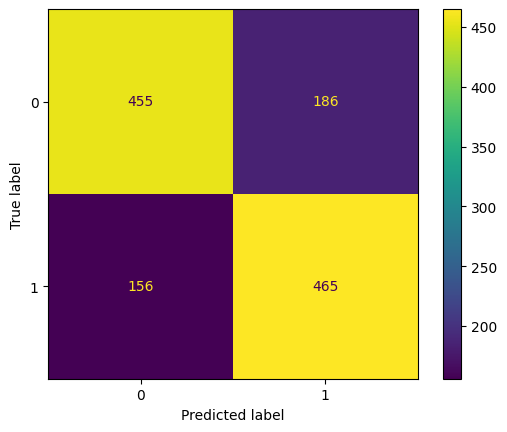

In [24]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=150)

classifier.fit(X_train, y_train)

print("TWEETS - ORIGINAL DATASET")
evaluating_results(X_test, y_test, classifier)

NEWS - ORIGINAL DATASET
Accuracy: 0.706
P=0.7352702901752836, R=0.6106531114151613, F1=0.600437072916157
              precision    recall  f1-score   support

           0     0.6963    0.9561    0.8058       319
           1     0.7742    0.2652    0.3951       181

    accuracy                         0.7060       500
   macro avg     0.7353    0.6107    0.6004       500
weighted avg     0.7245    0.7060    0.6571       500

[[305  14]
 [133  48]]


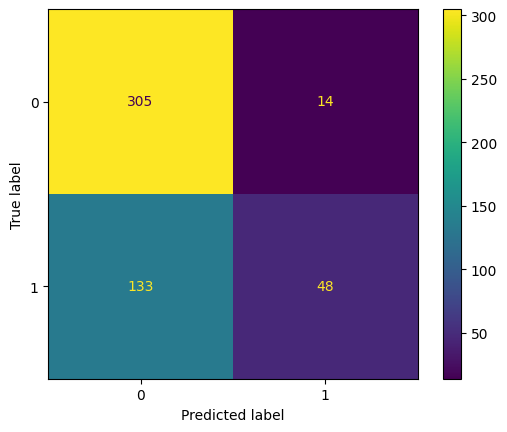

In [25]:
print("NEWS - ORIGINAL DATASET")
evaluating_results(X_test_news, y_test_news, classifier)

Training of the classifier on the undersampled test set

TWEETS - UNDERSAMPLED DATASET
Accuracy: 0.6394611727416799
P=0.6846838968778339, R=0.6432519136514253, F1=0.6195074887865337
              precision    recall  f1-score   support

           0     0.7801    0.4041    0.5324       641
           1     0.5892    0.8824    0.7066       621

    accuracy                         0.6395      1262
   macro avg     0.6847    0.6433    0.6195      1262
weighted avg     0.6862    0.6395    0.6181      1262

[[259 382]
 [ 73 548]]


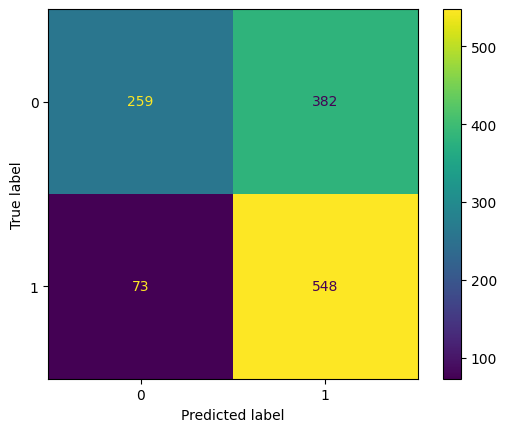

In [26]:
classifier = RandomForestClassifier(n_estimators=100)


classifier.fit(X_undersampled, y_undersampled)

print("TWEETS - UNDERSAMPLED DATASET")
evaluating_results(X_test, y_test, classifier)

NEWS - UNDERSAMPLED DATASET
Accuracy: 0.73
P=0.7099206349206348, R=0.6832383657493202, F1=0.6903087277882537
              precision    recall  f1-score   support

           0     0.7556    0.8527    0.8012       319
           1     0.6643    0.5138    0.5794       181

    accuracy                         0.7300       500
   macro avg     0.7099    0.6832    0.6903       500
weighted avg     0.7225    0.7300    0.7209       500

[[272  47]
 [ 88  93]]


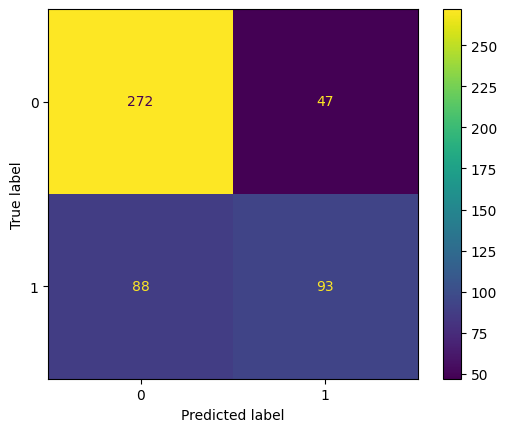

In [17]:

print("NEWS - UNDERSAMPLED DATASET")
evaluating_results(X_test_news, y_test_news, classifier)

Training of the classifier on the oversampled test set

TWEET - SMOTE DATASET
Accuracy: 0.6909667194928685
P=0.7054851869190129, R=0.6929741923976476, F1=0.6867744990224829
              precision    recall  f1-score   support

           0     0.7642    0.5663    0.6505       641
           1     0.6468    0.8196    0.7230       621

    accuracy                         0.6910      1262
   macro avg     0.7055    0.6930    0.6868      1262
weighted avg     0.7064    0.6910    0.6862      1262

[[363 278]
 [112 509]]


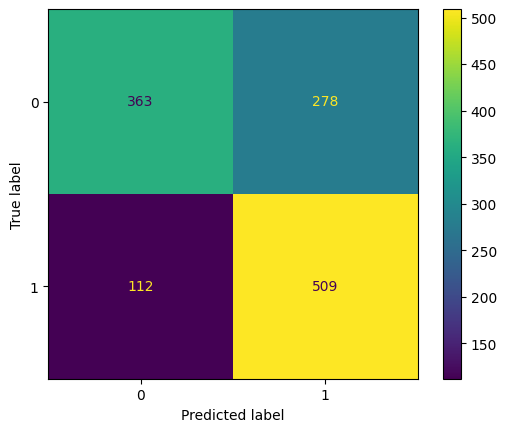

In [27]:
classifier = RandomForestClassifier(n_estimators=250)

classifier.fit(X_smote, y_smote)

print("TWEET - SMOTE DATASET")
evaluating_results(X_test, y_test, classifier)

NEWS - SMOTE DATASET
Accuracy: 0.724
P=0.7407112761130263, R=0.6414901539687213, F1=0.6431452864146961
              precision    recall  f1-score   support

           0     0.7160    0.9404    0.8130       319
           1     0.7654    0.3425    0.4733       181

    accuracy                         0.7240       500
   macro avg     0.7407    0.6415    0.6431       500
weighted avg     0.7339    0.7240    0.6900       500

[[300  19]
 [119  62]]


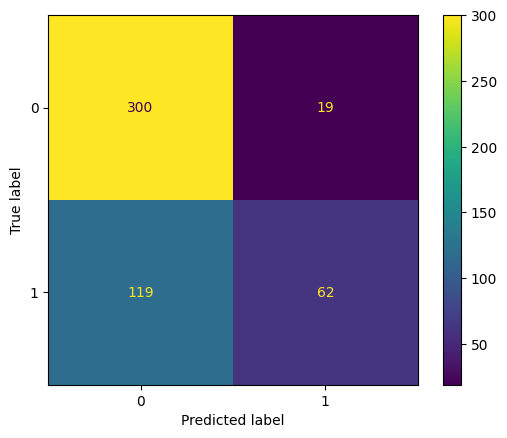

In [30]:
print("NEWS - SMOTE DATASET")
evaluating_results(X_test_news, y_test_news, classifier)


Maximum F1: 0.73 at K = 150


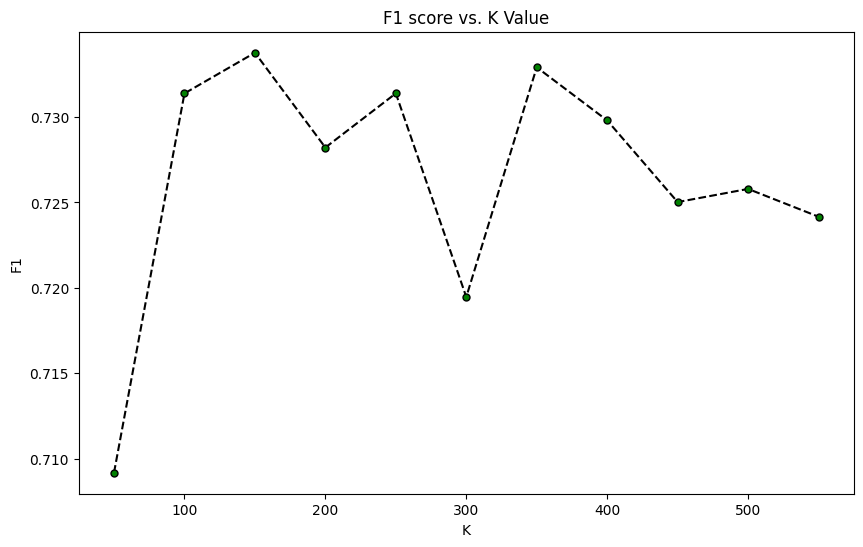

In [20]:
from sklearn import metrics

f_score = []

for i in range(50,600, 50):
    neigh = RandomForestClassifier(n_estimators = i).fit(X_train, y_train)
    yhat = neigh.predict(X_test)

    yhat =[int(x) for x in yhat]

    f_score.append(metrics.f1_score(y_test, yhat, average='macro'))


import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(range(50,600, 50), f_score, color = 'black',linestyle='dashed',
         marker='o',markerfacecolor='green', markersize=5)
plt.title('F1 score vs. K Value')
plt.xlabel('K')
plt.ylabel('F1')
print("Maximum F1:", round(max(f_score), 2 ) ,"at K =", f_score.index(max(f_score))*50 + 50)



Maximum F1: 0.64 at K = 100


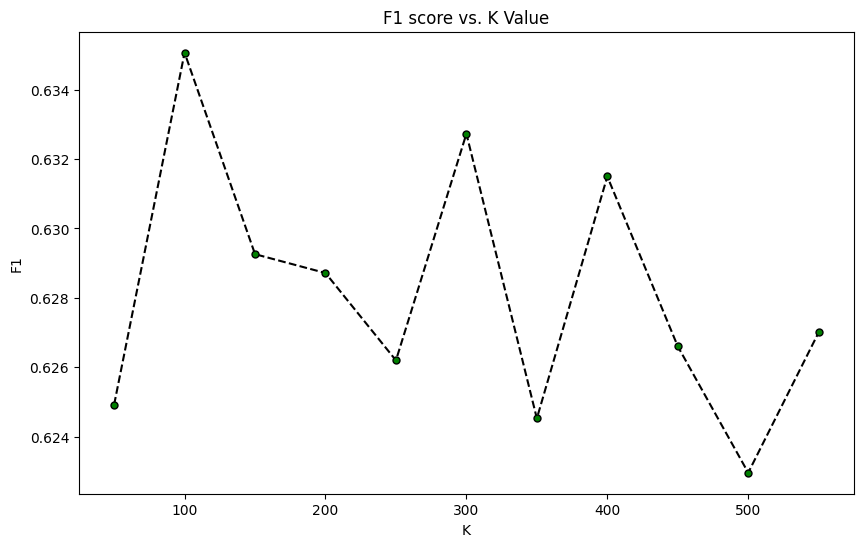

In [21]:
from sklearn import metrics

f_score = []

for i in range(50,600, 50):
    neigh = RandomForestClassifier(n_estimators = i).fit(X_undersampled, y_undersampled)
    yhat = neigh.predict(X_test)

    yhat =[int(x) for x in yhat]

    f_score.append(metrics.f1_score(y_test, yhat, average='macro'))

import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(range(50,600, 50), f_score, color = 'black',linestyle='dashed',
         marker='o',markerfacecolor='green', markersize=5)
plt.title('F1 score vs. K Value')
plt.xlabel('K')
plt.ylabel('F1')
print("Maximum F1:", round(max(f_score), 2 ) ,"at K =", f_score.index(max(f_score))*50 + 50)

Maximum F1: 0.71 at K = 250


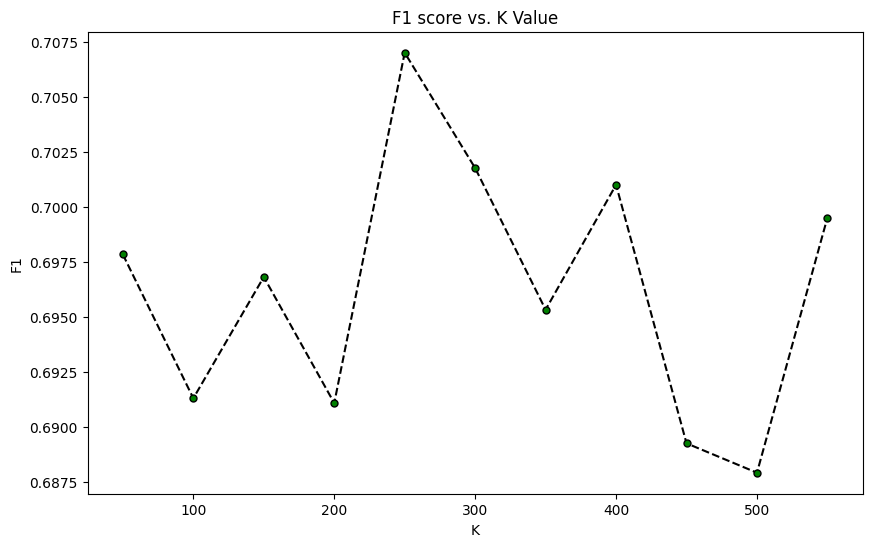

In [22]:
from sklearn import metrics

f_score = []

for i in range(50,600, 50):
    neigh = RandomForestClassifier(n_estimators = i).fit(X_smote, y_smote)
    yhat = neigh.predict(X_test)

    yhat =[int(x) for x in yhat]

    f_score.append(metrics.f1_score(y_test, yhat,  average='macro'))

import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(range(50,600, 50), f_score, color = 'black',linestyle='dashed',
         marker='o',markerfacecolor='green', markersize=5)
plt.title('F1 score vs. K Value')
plt.xlabel('K')
plt.ylabel('F1')
print("Maximum F1:", round(max(f_score), 2 ) ,"at K =", f_score.index(max(f_score))*50  +50)